# Dynamic Models for Building Energy Management


#### 31/05/2023

- Baptiste CARIOU
- Mariam CHENGUIR
- Marion GRALL
- Hugo MORAND

In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Introduction
Buildings' energy is a crucial field of study in our contemporary society, where sustainability and energy efficiency are major concerns. Residential, commercial, and industrial buildings represent a significant portion of global energy consumption, making it essential to understand and optimize their energy usage.

This work provides a comprehensive demonstration of conducting thermal dynamic simulations for building. To simplify the process, a toy model representing the building is utilized, featuring 4 identical walls, 1 other wall, 2 door, 1 window, air infiltration, and an indoor temperature control system in the room p1.

## 1. Model

### Description of the building

We consider this plan of a two-zone building : voir figure 1.

p1 is the left room and p2 is the right room.

It is considered that the exterior of top wall and the left wall is the outdoor and the exterior of the bottom wall and the right wall is the inside. There is no exchange with the inside, the bottom wall and the right wall are adiabatic.

It is considered that all the walls are made of concrete, the windows are made of glass, and the doors are made of wood.

We have all these values for the dimensions of our room : 

In [171]:
h = 2.5 #height of the walls (m)
e = 0.25 #thickness of all the walls except the one at the middle of the piece (m)
emilieu = 0.07 #thickness of the wall the middle of the piece (m)
Ltot = 10.26 #total length (m)
ltot = 7.20 #total width (m)

L_p1 = 3.36 #lenght of the room p1 (m)
L_p2 = 6.15 #length of the room p2 (m)
l = 6.70 #width of the room p1 and p2 (m)

S_p1 = 22.52 #surface of the room p1 (m²)
S_p2 = 41.17 #surface of the room p2 (m²)

h_fenetre = 1.20 #height of the window (m)
l_fenetre = 1 #width of the window (m)
S_fenetre = h_fenetre*l_fenetre #surface of the window (m²)

h_grande_porte = 2 #height of the door grande(m)
l_grande_porte = 1.40 #width of the door grande (m)
S_grande_porte = h_grande_porte*l_grande_porte #surface of the door grande (m²)

h_petite_porte = 2 #height of the door petite (m)
l_petite_porte = 0.90 #width of the door petite (m)
S_petite_porte = h_petite_porte*l_petite_porte #surface of the door petite (m²)

S_mur_exterieur=(Ltot*h-S_grande_porte)+(ltot*h-S_fenetre)

print ('S_fenetre =',S_fenetre)
print ('S_grande_porte =', S_grande_porte)
print ('S_petite_porte =', S_petite_porte)
print ('S_mur_exterieur =', S_mur_exterieur)

S_fenetre = 1.2
S_grande_porte = 2.8
S_petite_porte = 1.8
S_mur_exterieur = 39.65


We consider boundary conditions hypothesis:
- The sun is the same on the 2 exterior sides of the building while the 2 other sides are attached to building.
- The heat transfer is considered linear.
- We consider the ceiling and the floor's heat transfer neglected. 
- (The radiative exchanges are not taken into account.)

### Thermal circuit of the building

Now, we draw the thermall circuit : voir figure 2.

It is assumed that the wall in the middle of the room is thinner than the exterior walls, thus, the transfer between the two temperatures Tp1 and Tp2 can be reduced to E11.

### Thermo-physical properties

We are going to calculate the thermal conductances for conduction, convection, long-wave radiation, and advection and the thermal capacities. 

For this, we consider some thermophysical properties : 

In [172]:
h_ext = 25 #coefficient de convection de l'air extérieur (W/(m².K))
h_int = 8 #coefficient de convection de l'air intérieur (W/(m².K))
lambda_beton = 1.4 #conductivité du béton (W/(m.K))
lambda_verre = 1.4 #conductivité du verre (W/(m.K))
lambda_bois = 0.23 #conductivité du bois (W/(m.K))
w_beton = 0.25 #largeur du béton (m)
w_verre = 0.04 #largeur du verre (m)
rho_beton = 2300 #masse volumique du béton (kg/m3)
cp_beton = 880 #capacité thermique massique du béton (J/(K.kg))
rho_air = 1.2 #masse volumique de l'air (kg/m3)
cp_air = 1000 #capacité thermique massique de l'air (J/(K.kg))
Va = l**3 # m³, volume d'air
ACH = 1 # air échangé par heure
Va_dot = ACH / 3600 * Va # m³/s, infiltration d'air


### Thermal conductances

Then, we compute the thermal conductances for conduction, convection, long-wave radiation, and advection, according to the scheme :

In [173]:
#l'unité pour toutes ces valeurs est W/K

G1 = h_ext*S_fenetre+lambda_verre*S_fenetre/e+h_int*S_fenetre #fenêtre extérieur
G2 = h_ext*(l*h-S_fenetre) #convection mur extérieur p1 gauche
G3 = lambda_beton*(l*h-S_fenetre)*2/e #conduction mur p1 gauche
G4 = G3 #convection mur intérieur p1 gauche
G5 = h_int*(l*h-S_fenetre) #convection mur intérieur p1 gauche
G6 = h_ext*h*L_p1 #convection mur extérieur p1 haut
G7 = lambda_beton*h*L_p1*2/e #conduction mur p1 haut
G8 = G7 #conduction mur p1 haut
G9 = h_int*h*L_p1 #convection mur intérieur p1 haut
G10 = lambda_bois*S_petite_porte/emilieu #conduction de la porte intérieure
G11 = lambda_beton*(h*l-S_petite_porte)/emilieu #conduction du mur intérieur
G12 = lambda_bois*S_grande_porte/e+h_ext*S_grande_porte+h_int*S_grande_porte #conduction de la porte extérieur
G13 = h_ext*(L_p2*h-S_grande_porte) #convection mur extérieur p2 haut
G14 = lambda_beton*(L_p2*h-S_grande_porte)*2/e #conduction mur p2 haut
G15 = G14 #conduction mur p2 haut
G16 = h_int*(L_p2*h-S_grande_porte) #convection mur intérieur p2 haut
G17 = rho_air*cp_air*Va_dot #advection ventilation

print ('G1 =', G1)
print ('G2 =', G2)
print ('G3 =', G3)
print ('G4 =', G4)
print ('G5 =', G5)
print ('G6 =', G6)
print ('G7 =', G7)
print ('G8 =', G8)
print ('G9 =', G9)
print ('G10 =', G10)
print ('G11 =', G11)
print ('G12 =', G12)
print ('G13 =', G13)
print ('G14 =', G14)
print ('G15 =', G15)
print ('G16 =', G16)
print ('G17 =', G17)



G1 = 46.32
G2 = 388.75
G3 = 174.16
G4 = 174.16
G5 = 124.4
G6 = 210.0
G7 = 94.08
G8 = 94.08
G9 = 67.2
G10 = 5.914285714285715
G11 = 298.99999999999994
G12 = 94.976
G13 = 314.375
G14 = 140.83999999999997
G15 = 140.83999999999997
G16 = 100.6
G17 = 100.25433333333335


### Thermal capacities

Then, we compute the thermal capacities : 

In [174]:
#l'unité pour toutes ces valeurs est J/K

CW1 = rho_beton*cp_beton*e*(l*h-S_fenetre) #capacité thermique du mur gauche p1
CW2 = rho_beton*cp_beton*e*L_p1*h #capacité therpmique du mur haut p1
CW3 = rho_beton*cp_beton*e*(h*L_p2-S_grande_porte) #capacité thermique du mur haut p2
CA1 = rho_air*cp_air*h*l*L_p1 #capacité thermique de l'air dans p1
CA2 = rho_air*cp_air*h*l*L_p2 #capacité thermique de l'air dans p2

print('CW1 =',CW1)
print('CW2 =',CW2)
print('CW3 =',CW3)
print('CA1 =',CA1)
print('CA2 =',CA2)

CW1 = 7868300.0
CW2 = 4250400.0
CW3 = 6362950.0
CA1 = 67536.0
CA2 = 123615.0


### Temperatures

In [175]:
"""T5=T1
T9=T5
T11=T10
T12=T11
T16=T12

# Mur p1 gauche
e1=T0-T1
e2=T0-T2
e3=T2-T3
e4=T3-T4
e5=T4-T5

# Mur p1 haut
e6=T0-T6
e7=T6-T7
e8=T7-T8
e9=T8-T9

# Mur du milieu
e10=T9-T10
e11=T9-T11

# Mur p2 haut
e12=T0-T10
e13=T0-T13
e14=T13-T14
e15=T14-T15
e16=T15-T16
e17=Tisp-T1"""

'T5=T1\nT9=T5\nT11=T10\nT12=T11\nT16=T12\n\n# Mur p1 gauche\ne1=T0-T1\ne2=T0-T2\ne3=T2-T3\ne4=T3-T4\ne5=T4-T5\n\n# Mur p1 haut\ne6=T0-T6\ne7=T6-T7\ne8=T7-T8\ne9=T8-T9\n\n# Mur du milieu\ne10=T9-T10\ne11=T9-T11\n\n# Mur p2 haut\ne12=T0-T10\ne13=T0-T13\ne14=T13-T14\ne15=T14-T15\ne16=T15-T16\ne17=Tisp-T1'

### System of algebraic-differentiel equations (DAE)

After that, we obtain the incidence matrix A, the conductance matrix G and the capacity matrix C of the system of Algebraic Differential Equations :

In [176]:
"""
A=np.zeros(17,11) : incidence matrix
G=np.zeros(17,17) : conductance matrix
C=np.zeros(11,11) : capacity matrix
e=np.zeros(17,1) : difference of temperatures vector
b=np.zeros(17,1) : temperature source vector
f=np.zeros(11,1) : heat flow source vector
T=np.zeros(11,1) : temperature vector
y=np.zeros(11,1) : output vector
"""

'\nA=np.zeros(17,11) : incidence matrix\nG=np.zeros(17,17) : conductance matrix\nC=np.zeros(11,11) : capacity matrix\ne=np.zeros(17,1) : difference of temperatures vector\nb=np.zeros(17,1) : temperature source vector\nf=np.zeros(11,1) : heat flow source vector\nT=np.zeros(11,1) : temperature vector\ny=np.zeros(11,1) : output vector\n'

In [177]:
# Matrice A

A=np.array([
[1,0,0,0,0,0,0,0,0,0,0], #1
[0,1,0,0,0,0,0,0,0,0,0], #2
[0,-1,1,0,0,0,0,0,0,0,0], #3
[0,0,-1,1,0,0,0,0,0,0,0], #4
[1,0,0,-1,0,0,0,0,0,0,0], #5
[0,0,0,0,1,0,0,0,0,0,0], #6
[0,0,0,0,-1,1,0,0,0,0,0], #7
[0,0,0,0,0,-1,1,0,0,0,0], #8
[1,0,0,0,0,0,-1,0,0,0,0], #9
[-1,0,0,0,0,0,0,1,0,0,0], #10
[-1,0,0,0,0,0,0,1,0,0,0], #11
[0,0,0,0,0,0,0,1,0,0,0], #12
[0,0,0,0,0,0,0,0,1,0,0], #13
[0,0,0,0,0,0,0,0,-1,1,0], #14
[0,0,0,0,0,0,0,0,0,-1,1], #15
[0,0,0,0,0,0,0,1,0,0,-1],#16
[1,0,0,0,0,0,0,0,0,0,0], #17
])

print(A)


[[ 1  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0]
 [ 0 -1  1  0  0  0  0  0  0  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0  0]
 [ 1  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0 -1  1  0  0  0  0  0]
 [ 0  0  0  0  0 -1  1  0  0  0  0]
 [ 1  0  0  0  0  0 -1  0  0  0  0]
 [-1  0  0  0  0  0  0  1  0  0  0]
 [-1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0 -1  1  0]
 [ 0  0  0  0  0  0  0  0  0 -1  1]
 [ 0  0  0  0  0  0  0  1  0  0 -1]
 [ 1  0  0  0  0  0  0  0  0  0  0]]


In [178]:
# Matrice G

G=np.array([
[G1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], #1
[0,G2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], #2
[0,0,G3,0,0,0,0,0,0,0,0,0,0,0,0,0,0], #3
[0,0,0,G4,0,0,0,0,0,0,0,0,0,0,0,0,0], #4
[0,0,0,0,G5,0,0,0,0,0,0,0,0,0,0,0,0], #5
[0,0,0,0,0,G6,0,0,0,0,0,0,0,0,0,0,0], #6
[0,0,0,0,0,0,G7,0,0,0,0,0,0,0,0,0,0], #7
[0,0,0,0,0,0,0,G8,0,0,0,0,0,0,0,0,0], #8
[0,0,0,0,0,0,0,0,G9,0,0,0,0,0,0,0,0], #9
[0,0,0,0,0,0,0,0,0,G10,0,0,0,0,0,0,0], #10
[0,0,0,0,0,0,0,0,0,0,G11,0,0,0,0,0,0], #11
[0,0,0,0,0,0,0,0,0,0,0,G12,0,0,0,0,0], #12
[0,0,0,0,0,0,0,0,0,0,0,0,G13,0,0,0,0], #13
[0,0,0,0,0,0,0,0,0,0,0,0,0,G14,0,0,0], #14
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,G15,0,0], #15
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,G16,0], #16
[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,G17], #17
])

print(G)

[[ 46.32         0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [  0.         388.75         0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [  0.           0.         174.16         0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [  0.           0.           0.         174.16         0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.        ]
 [  0.           0.           0.           0.         124.4
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0

In [179]:
# Matrice C

C=np.array([
[CA1,0,0,0,0,0,0,0,0,0,0], #1
[0,0,0,0,0,0,0,0,0,0,0], #2
[0,0,CW1,0,0,0,0,0,0,0,0], #3
[0,0,0,0,0,0,0,0,0,0,0], #4
[0,0,0,0,0,0,0,0,0,0,0], #5
[0,0,0,0,0,CW2,0,0,0,0,0], #6
[0,0,0,0,0,0,0,0,0,0,0], #7
[0,0,0,0,0,0,0,CA2,0,0,0], #8
[0,0,0,0,0,0,0,0,0,0,0], #9
[0,0,0,0,0,0,0,0,0,CW3,0], #10
[0,0,0,0,0,0,0,0,0,0,0], #11
])

print(C)

[[  67536.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0. 7868300.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0. 4250400.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.  123615.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.
        0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.

In [180]:
# Vecteur b

b = np.zeros(17) # branches
b[[0, 1, 5, 11, 12]] = 10 # branches with temperature sources T0=10°C
b[16]=20 # branch with temperature source Tisp=20°C
print(f'b = ', b)

b =  [10. 10.  0.  0.  0. 10.  0.  0.  0.  0.  0. 10. 10.  0.  0.  0. 20.]


In [181]:
# Vecteur f

f = np.zeros(11) # nodes
f[[0,1,3,4,6,7,8,10]] = 1 # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.]


In [182]:
# Vecteur y

y = np.zeros(11) # nodes
y[[0,7]] = 1 # nodes (temperatures) of interest T1 and T8 (i.e. temperatures of the room p1 and p2)
print(f'y = ', y)

y =  [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## 2. Steady-state

### State-space representation

The differential-algebraic system of equations (DAE)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in state-space representation:

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

The state-space representation, i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$.

In [183]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

As = 
 [[-8.34007471e-03  1.07448867e-03  5.80431177e-04  4.51484076e-03
   0.00000000e+00]
 [ 9.22266140e-06 -2.45088405e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 9.22266140e-06  0.00000000e+00 -2.45088405e-05  0.00000000e+00
   0.00000000e+00]
 [ 2.46664471e-03  0.00000000e+00  0.00000000e+00 -3.70969234e-03
   4.74726638e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.22266140e-06
  -2.45088405e-05]] 

Bs = 
 [[6.85856432e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.48445767e-03 1.48069178e-05 0.00000000e+00
  6.16954908e-06 0.00000000e+00 6.16954908e-06 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.52861791e-05 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.93213611e-08
  7.41371495e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.52861791e-05 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e

### Steady-state

Steady-state means that the term $C \dot \theta = 0$ in the system of DAE.

In steady-state, the model can be checked if it is incorrect. Let's consider that:
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- the indoor temperature setpoint is $T_{i,sp} = 20 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [184]:
# Vecteur b

b[[0, 1, 5, 11, 12]] = 10 # outdoor temperature T0=10°C
b[16]=20 # indoor set-point temperature Tisp=20°C
print(f'b = ', b)

# Vecteur f

f[[0,1,3,4,6,7,8,10]] = 0 # nodes with heat-flow sources
print(f'f = ', f)

b =  [10. 10.  0.  0.  0. 10.  0.  0.  0.  0.  0. 10. 10.  0.  0.  0. 20.]
f =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### System of Diferential Algebraic Equations (DAE)
The value of temperature in steady-state is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$


In [185]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [13.25292707 10.37871916 11.22407443 12.06942969 10.37871916 11.22407443
 12.06942969 12.27235766 10.26455723 10.85508677 11.44561631] °C


### State-space representation

The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

In [186]:
bT = np.array([10, 10, 10, 10, 10, 20]) # [To,To,To,To,To,Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0]) # flux
u = np.hstack([bT, fQ])
print(f'bT = {bT}')
print(f'fQ = {fQ}')
print(f'u = {u}')


bT = [10 10 10 10 10 20]
fQ = [0 0 0 0 0 0 0 0]
u = [10 10 10 10 10 20  0  0  0  0  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [187]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [13.25292707 12.27235766] °C


The error between the steady-state values obtained from the system of DAE, $\theta_i$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_i - y_{ss} \right |$$

is practically zero; the slight difference is due to numerical errors.

In [188]:
for i in range(11):
    print(f'Max error between DAE and state-space: \
    {max(abs(θ[i] - yss)):.2e} °C')

Max error between DAE and state-space:     9.81e-01 °C
Max error between DAE and state-space:     2.87e+00 °C
Max error between DAE and state-space:     2.03e+00 °C
Max error between DAE and state-space:     1.18e+00 °C
Max error between DAE and state-space:     2.87e+00 °C
Max error between DAE and state-space:     2.03e+00 °C
Max error between DAE and state-space:     1.18e+00 °C
Max error between DAE and state-space:     9.81e-01 °C
Max error between DAE and state-space:     2.99e+00 °C
Max error between DAE and state-space:     2.40e+00 °C
Max error between DAE and state-space:     1.81e+00 °C


Les résultats obtenu avec les deux méthodes sont sensiblement les mêmes, comme on peut le voir les erreurs sont faibles. En particulier, pour les températures des pièces, on observe que l'erreur est inférieure à 1°C (0,981°C).

## 3. Simulate step response

### Time step

The condition for numerical stability of Euler explicit integration method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition becomes

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the time constants, $T_i = - \frac{1}{\lambda_i} $

In [189]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [   99.12993046   508.45586927 48419.27588996 42333.13021699
 40801.6038016 ] s 

2 x Time constants: 
 [  198.25986091  1016.91173854 96838.55177993 84666.26043398
 81603.20760321] s 

Maximum time step: 198.26 s = 3.30 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [190]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 180.0 s = 3 min


### Settling time
The settling time is roughly 4 times the larger time constant.

In [191]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [   396   2032 163204 169332 193676] s 

Settling time: 193677 s = 3228.0 min = 53.80 h = 2.24 days


### Step response
Let's obtain the dynamic response of the system to a step input.

#### Duration
The duration of the simulation needs to be larger than the estimated settling time. This requires a corresponding number of time steps in the time vector.

In [192]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 194400.0 s
Number of time steps = 1080


### Input vector

In dynamic simulation, the inputs are time series, e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]^T$ at discrete time] $t = [t_0, t_1, ... , t_{n-1}]^T$.

In [193]:
'''
bT = np.array([10, 10, 10, 10, 10, 20]) # [To,To,To,To,To,Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0]) # flux
u = np.hstack([bT, fQ])
print(f'u = ', u)
'''


u = np.zeros([14, n]) # u = [To,To,To,To,To,Tisp,flux(x8)]
u[0:5, :] = 10 * np.ones([5, n]) # To = 10 for n time steps
u[5, :] = 20 * np.ones([1, n]) # Tisp = 20 for n time steps
print(f'u = ', u)

# pd.DataFrame(u)

u =  [[10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]
 [10. 10. 10. ... 10. 10. 10.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


### Time integration

By integrating the state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

by using Euler forward (or explicit) method for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and Euler backward (or implicit) method for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [194]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [195]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
print(f'y_exp = ', y_exp)
print(f'y_imp = ', y_imp)


y_exp =  [[ 0.          6.5785892   4.41341459 ... 13.16764912 13.16796614
  13.16828198]
 [ 0.          1.38297779  4.7656984  ... 12.18996024 12.19026656
  12.19057174]]
y_imp =  [[ 0.          3.17896057  4.9331589  ... 13.16637037 13.16669095
  13.16701034]
 [ 0.          1.67711615  3.15141136 ... 12.18872457 12.18903433
  12.18934295]]


The results of explicit and implicit Euler integration are practically identical.

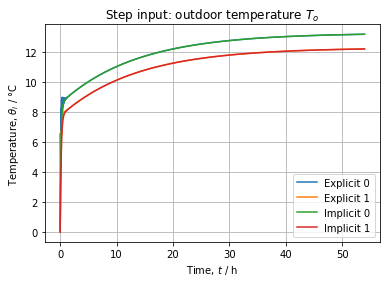

In [196]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperature, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')

# Ajout des légendes
legend_labels = ['Explicit ' + str(i) for i in range(y_exp.shape[0])]
legend_labels += ['Implicit ' + str(i) for i in range(y_imp.shape[0])]
ax.legend(legend_labels)

ax.grid()
plt.show()


The value the indoor temperature obtained after the settling time is almost equal to the value obtained in steady-state.

In [236]:
print('Steady-state indoor temperature for p1 obtained with:')
print(f'- DAE model: {float(θ[0]):.4f} °C')
print(f'- state-space model: {float(yss[0]):.4f} °C')
print(f'- steady-state response to step input: {(y_exp[0, -2]):.4f} °C')

print('Steady-state indoor temperature for p2 obtained with:')
print(f'- DAE model: {float(θ[7]):.4f} °C')
print(f'- state-space model: {float(yss[1]):.4f} °C')
print(f'- steady-state response to step input: {(y_exp[1, -2]):.4f} °C')

Steady-state indoor temperature for p1 obtained with:
- DAE model: 13.2529 °C
- state-space model: 13.2529 °C
- steady-state response to step input: 14.4360 °C
Steady-state indoor temperature for p2 obtained with:
- DAE model: 12.2724 °C
- state-space model: 12.2724 °C
- steady-state response to step input: 13.2472 °C


We notice that both the DAE model and the state-space model yield identical temperatures for room p1 on one hand, and room p2 on the other hand. However, the steady-state model returns a slightly higher temperature in both cases, approximately 1°C higher.

## 4. Simulate response to weather

### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [237]:
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [238]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date


### Inputs
#### Read weather data

Dynamic simulation needs time series of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface.

In [239]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar direct normal irradiance (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or diffuse sky radiation), W/m²;

from the start to the end date.

In [240]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

#### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth` and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,

for hourly solar irradiance on a tilted surface.

In [241]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

The total solar irradiance $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components.  

In [242]:
rad_surf['Φtot'] = rad_surf.sum(axis=1)

#### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [243]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)

#### Other inputs
Let's consider the indoor temperature setpoint $T_{i,sp} = 20 \, \mathrm{^\circ C}$ and the auxiliary heat flow $\dot{Q}_a = 0 \, \mathrm{W}$ constant for the whole duration of the simulation.

In [244]:
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

#### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_{i,sp}\\ 
\Phi_o\\ 
\Phi_i\\ 
\dot{Q}_a\\ 
\Phi_a
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
 T_{i,sp(0)} & T_{i,sp(1)}& ... & T_{i,sp(n-1)}\ \\ 
\Phi_{o,(0)} & \Phi_{o,(1)} & ... & \Phi_{o,(n-1)}\\
\Phi_{i,(0)} & \Phi_{i,(1)} & ... & \Phi_{i,(n-1)}\\ 
 \dot{Q}_{a(0)} & \dot{Q}_{a(1)} & ... & \dot{Q}_{a(n-1)}\\ 
\Phi_{a,(0)} & \Phi_{a,(1)} & ... & \Phi_{a,(n-1)}
\end{bmatrix}$$

where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$T_{i,sp}$: time series vector of indoor setpoint temperatures, °C.

$\Phi_o$: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the wall:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_i$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the wall:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\dot{Q}_a$: time vector of auxiliary heat flows (from occupants, electrical devices, etc.), W.

$\Phi_a$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the window glass:

$$\Phi_a = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

In [245]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * S_mur_exterieur * data['Φtot']
Φi = τ_gSW * α_wSW * S_fenetre * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * S_fenetre * data['Φtot']

u = pd.concat([To, To, To, To, To, Ti, Qa, Φo, Φi, Φo, Φi, Qa, Φo, Φi], axis=1)

u.columns.values[[7, 8, 9,10,12,13]] = ['Φo', 'Φi', 'Φo','Φi','Φo','Φi']
# pd.DataFrame(u)

### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [246]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

### Time integration
Explicit Euler integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [247]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

and the variation of the heat flow of the HVAC system:

$$q_{HVAC} = K_p (T_{i,sp} - \theta_i) = K_p (T_{i,sp} - y)$$

where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

## Conclusion

We have reached this part, we couldn't go any further. This project allowed us to model the thermal behavior of a building in a simplified manner to understand the phenomena that can occur.